In [1]:
import tensorflow as tf

C:\Users\lijin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Load the x and y vectors for training neural network

import numpy as np

x = np.load('x_lda_max_bcs.npy')
x_test = np.load('x_lda_test_max_bcs.npy')
y = np.load('toxic_classification_trainlabel_2.npy')
y_test = np.load('toxic_classification_testlabel_2.npy')

In [3]:
x_train,y_train = x,y

In [4]:
#Reshape test data to have vector dimension as train data

x_test = np.resize(x_test, (x_test.shape[0], x_train.shape[1]))

In [5]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(16198, 1250)
(6231, 1250)
(16198, 6)
(6231, 6)


In [6]:
import matplotlib.pyplot as plt

def plot_bar_chart(hamming_loss, zero_one_loss, num_folds):
    # data to plot

    k_fold = ["Fold {}".format(i+1) for i in range(num_folds)]
    # create plot
    fig, ax = plt.subplots()
    index = np.arange(num_folds)
    bar_width = 0.35
    opacity = 0.8

    rects1 = plt.bar(index + 1.5*bar_width, hamming_loss, bar_width,
    alpha=opacity,
    color='g',
    label='Hamming loss')

    rects2 = plt.bar(index, zero_one_loss, bar_width,
    align = 'edge',
    alpha=opacity,
    color='b',
    label='Zero-One loss')

    plt.xlabel('Loss functions')
    plt.ylabel('Loss values')
    plt.title('Evaluation on Validation data')
    plt.xticks(index + bar_width, k_fold)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
THRESHOLD = 0.5

from sklearn import metrics

def classification_report(true, pred, num_topics):
    topics = ["Label "+str(x+1) for x in range(num_topics)]

    targets = np.vstack(true)
    pred_classes = np.vstack(pred)

    print(metrics.classification_report(targets == 1, pred_classes > THRESHOLD, target_names=topics))
    #print(metrics.confusion_matrix(targets.argmax(axis=1), pred_classes.argmax(axis=1)))

In [8]:
n_input = x_train.shape[1]
num_units = 1024

In [9]:
validation_loss = []
hamming_loss = []
zero_one_loss = []

class myCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.aucs = []
    
    def on_train_end(self, logs={}):
        validation_results = model.predict(x_train[val])
        validation_loss.append(model.evaluate(x_train[val], y_train[val], batch_size=1000)[0])
        
        targets = np.vstack(y_train[val])
        pred_classes = np.vstack(validation_results)
        
        print('\n')
        print(f'Validation results ...')
        #classification_report(y_train[val], validation_results, y_train.shape[1])
        
        hl = metrics.hamming_loss(targets == 1, pred_classes > THRESHOLD, sample_weight=None)
        zol = metrics.zero_one_loss(targets == 1, pred_classes > THRESHOLD, normalize=True, sample_weight=None)
        
        print('Hamming loss:')
        print(hl)
        print('Zero one loss:')
        print(zol)
        hamming_loss.append(hl)
        zero_one_loss.append(zol)
        
        #print('Jaccard score:')
        #print(metrics.jaccard_similarity_score(targets >=1, pred_classes > THRESHOLD, normalize=True, sample_weight=None))
        #print('Accuracy score:')
        #print(metrics.accuracy_score(targets >=1, pred_classes > THRESHOLD, normalize=True, sample_weight=None))
        return
 
    def on_epoch_begin(self, epoch, logs={}):        
        return
 
    def on_epoch_end(self, epoch, logs={}):
        return
    
    def on_predict_begin(self, epoch, logs={}):
        return
    
    def on_predict_end(self, epoch, logs={}):
        return

In [10]:
# Instantiate a callback object
callbacks = myCallback()

from sklearn.model_selection import KFold

# Model configuration
batch_size = 1000
num_folds = 6

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

In [11]:
# K-fold Cross Validation model evaluation

fold_no = 1
for train, val in kfold.split(x_train):

    # Build a conv dnn model
    
    inputs = tf.keras.Input(shape = (x_train.shape[1],))
    mask = tf.keras.layers.Masking(mask_value=0.0)(inputs)
    d1 = tf.keras.layers.Dense(1024, activation="relu")(mask)
    d2 = tf.keras.layers.Dense(256, activation="relu")(d1)
    outputs = tf.keras.layers.Dense(y_train.shape[1], activation="sigmoid")(d2)

    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=["binary_accuracy",
                         "categorical_accuracy"
                        ])
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    # Fit data to model
    model.fit(x_train[train], y_train[train], epochs=100, 
              batch_size=batch_size, callbacks=[callbacks,tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss')],
              validation_data=(x_train[val], y_train[val]), verbose=1)
    
    # Increase fold number
    fold_no = fold_no + 1

W1019 18:59:31.883522 14296 deprecation.py:506] From C:\Users\lijin\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1019 18:59:32.071022 14296 deprecation.py:323] From C:\Users\lijin\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


------------------------------------------------------------------------
Training for fold 1 ...
Train on 13498 samples, validate on 2700 samples
Epoch 1/100
13498/13498 [==============================] - 1s 73us/sample - loss: 0.4614 - binary_accuracy: 0.7768 - categorical_accuracy: 0.8745 - val_loss: 0.4125 - val_binary_accuracy: 0.8022 - val_categorical_accuracy: 0.9418
Epoch 2/100
13498/13498 [==============================] - 0s 31us/sample - loss: 0.4017 - binary_accuracy: 0.8006 - categorical_accuracy: 0.9426 - val_loss: 0.4010 - val_binary_accuracy: 0.8024 - val_categorical_accuracy: 0.9418
Epoch 3/100
13498/13498 [==============================] - 0s 32us/sample - loss: 0.3948 - binary_accuracy: 0.8042 - categorical_accuracy: 0.9426 - val_loss: 0.3992 - val_binary_accuracy: 0.8002 - val_categorical_accuracy: 0.9418
Epoch 4/100
13498/13498 [==============================] - 0s 30us/sample - loss: 0.3918 - binary_accuracy: 0.8071 - categorical_accuracy: 0.9426 - val_loss: 0.3965

Epoch 36/100
13498/13498 [==============================] - 0s 31us/sample - loss: 0.2945 - binary_accuracy: 0.8749 - categorical_accuracy: 0.9199 - val_loss: 0.3631 - val_binary_accuracy: 0.8463 - val_categorical_accuracy: 0.9154
Epoch 37/100
13498/13498 [==============================] - 0s 30us/sample - loss: 0.2895 - binary_accuracy: 0.8784 - categorical_accuracy: 0.9219 - val_loss: 0.3693 - val_binary_accuracy: 0.8429 - val_categorical_accuracy: 0.8980
Epoch 38/100
2700/2700 [==============================] - 0s 17us/sample - loss: 0.3699 - binary_accuracy: 0.8456 - categorical_accuracy: 0.8928


Validation results ...
Hamming loss:
0.15469135802469136
Zero one loss:
0.5951851851851853
------------------------------------------------------------------------
Training for fold 2 ...
Train on 13498 samples, validate on 2700 samples
Epoch 1/100
13498/13498 [==============================] - 1s 54us/sample - loss: 0.4679 - binary_accuracy: 0.7597 - categorical_accuracy: 0.8736 - val_lo

Epoch 32/100
13498/13498 [==============================] - 0s 32us/sample - loss: 0.3030 - binary_accuracy: 0.8687 - categorical_accuracy: 0.9214 - val_loss: 0.3549 - val_binary_accuracy: 0.8470 - val_categorical_accuracy: 0.9277
Epoch 33/100
13498/13498 [==============================] - 0s 34us/sample - loss: 0.2949 - binary_accuracy: 0.8759 - categorical_accuracy: 0.9254 - val_loss: 0.3635 - val_binary_accuracy: 0.8459 - val_categorical_accuracy: 0.9173
Epoch 34/100
13498/13498 [==============================] - 0s 33us/sample - loss: 0.2918 - binary_accuracy: 0.8770 - categorical_accuracy: 0.9248 - val_loss: 0.3600 - val_binary_accuracy: 0.8469 - val_categorical_accuracy: 0.9306
Epoch 35/100
13498/13498 [==============================] - 0s 33us/sample - loss: 0.2921 - binary_accuracy: 0.8765 - categorical_accuracy: 0.9221 - val_loss: 0.3650 - val_binary_accuracy: 0.8464 - val_categorical_accuracy: 0.9232
Epoch 36/100
13498/13498 [==============================] - 0s 33us/sample -

Epoch 29/100
13498/13498 [==============================] - 0s 34us/sample - loss: 0.3059 - binary_accuracy: 0.8711 - categorical_accuracy: 0.9254 - val_loss: 0.3695 - val_binary_accuracy: 0.8367 - val_categorical_accuracy: 0.9146
Epoch 30/100
13498/13498 [==============================] - 0s 33us/sample - loss: 0.3059 - binary_accuracy: 0.8694 - categorical_accuracy: 0.9240 - val_loss: 0.3596 - val_binary_accuracy: 0.8470 - val_categorical_accuracy: 0.9417
Epoch 31/100
13498/13498 [==============================] - 0s 33us/sample - loss: 0.3053 - binary_accuracy: 0.8697 - categorical_accuracy: 0.9215 - val_loss: 0.3623 - val_binary_accuracy: 0.8432 - val_categorical_accuracy: 0.9421
Epoch 32/100
13498/13498 [==============================] - 0s 34us/sample - loss: 0.2993 - binary_accuracy: 0.8744 - categorical_accuracy: 0.9229 - val_loss: 0.3622 - val_binary_accuracy: 0.8457 - val_categorical_accuracy: 0.9354
Epoch 33/100
13498/13498 [==============================] - 0s 33us/sample -

Epoch 24/100
13498/13498 [==============================] - 0s 34us/sample - loss: 0.3077 - binary_accuracy: 0.8696 - categorical_accuracy: 0.9343 - val_loss: 0.3666 - val_binary_accuracy: 0.8409 - val_categorical_accuracy: 0.9155
Epoch 25/100
13498/13498 [==============================] - 0s 33us/sample - loss: 0.3083 - binary_accuracy: 0.8691 - categorical_accuracy: 0.9331 - val_loss: 0.3660 - val_binary_accuracy: 0.8422 - val_categorical_accuracy: 0.9362
Epoch 26/100
13498/13498 [==============================] - 0s 33us/sample - loss: 0.3038 - binary_accuracy: 0.8720 - categorical_accuracy: 0.9328 - val_loss: 0.3677 - val_binary_accuracy: 0.8412 - val_categorical_accuracy: 0.9333
Epoch 27/100
13498/13498 [==============================] - 0s 33us/sample - loss: 0.3024 - binary_accuracy: 0.8730 - categorical_accuracy: 0.9314 - val_loss: 0.3774 - val_binary_accuracy: 0.8366 - val_categorical_accuracy: 0.9195
Epoch 28/100
13498/13498 [==============================] - 0s 34us/sample -

Epoch 19/100
13499/13499 [==============================] - 0s 34us/sample - loss: 0.3208 - binary_accuracy: 0.8635 - categorical_accuracy: 0.9368 - val_loss: 0.3545 - val_binary_accuracy: 0.8453 - val_categorical_accuracy: 0.9350
Epoch 20/100
13499/13499 [==============================] - 0s 33us/sample - loss: 0.3185 - binary_accuracy: 0.8644 - categorical_accuracy: 0.9341 - val_loss: 0.3564 - val_binary_accuracy: 0.8453 - val_categorical_accuracy: 0.9388
Epoch 21/100
13499/13499 [==============================] - 0s 33us/sample - loss: 0.3160 - binary_accuracy: 0.8655 - categorical_accuracy: 0.9324 - val_loss: 0.3561 - val_binary_accuracy: 0.8442 - val_categorical_accuracy: 0.9339
Epoch 22/100
13499/13499 [==============================] - 0s 33us/sample - loss: 0.3148 - binary_accuracy: 0.8660 - categorical_accuracy: 0.9303 - val_loss: 0.3532 - val_binary_accuracy: 0.8449 - val_categorical_accuracy: 0.9343
Epoch 23/100
13499/13499 [==============================] - 0s 33us/sample -

Epoch 11/100
13499/13499 [==============================] - 0s 33us/sample - loss: 0.3581 - binary_accuracy: 0.8449 - categorical_accuracy: 0.9425 - val_loss: 0.3696 - val_binary_accuracy: 0.8373 - val_categorical_accuracy: 0.9422
Epoch 12/100
13499/13499 [==============================] - 0s 34us/sample - loss: 0.3513 - binary_accuracy: 0.8462 - categorical_accuracy: 0.9425 - val_loss: 0.3643 - val_binary_accuracy: 0.8388 - val_categorical_accuracy: 0.9422
Epoch 13/100
13499/13499 [==============================] - 0s 33us/sample - loss: 0.3432 - binary_accuracy: 0.8517 - categorical_accuracy: 0.9427 - val_loss: 0.3613 - val_binary_accuracy: 0.8389 - val_categorical_accuracy: 0.9418
Epoch 14/100
13499/13499 [==============================] - 0s 34us/sample - loss: 0.3393 - binary_accuracy: 0.8523 - categorical_accuracy: 0.9424 - val_loss: 0.3587 - val_binary_accuracy: 0.8404 - val_categorical_accuracy: 0.9422
Epoch 15/100
13499/13499 [==============================] - 0s 33us/sample -

Average validation loss:
0.37724607430204854
Average hamming loss:
0.15728299385384314
Average Zero one loss:
0.6028519250385372


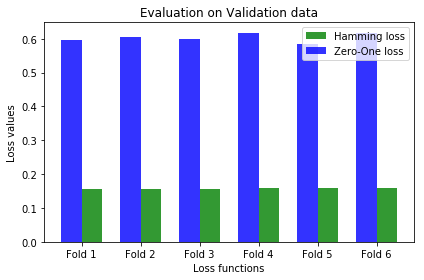

In [12]:
print('Average validation loss:')
print(sum(validation_loss)/len(hamming_loss))
print('Average hamming loss:')
print(sum(hamming_loss)/len(hamming_loss))
print('Average Zero one loss:')
print(sum(zero_one_loss)/len(zero_one_loss))
plot_bar_chart(hamming_loss, zero_one_loss, num_folds)

In [13]:
model.save('tf_model_LDA_max_bcs') 
model.save('tf_model_LDA_max_bcs.model') 

In [14]:
#model = tf.keras.models.load_model('tf_model_LDA_max_bcs')
y_predict = model.predict(x_test)
test_eval = model.evaluate(x_test, y_test, batch_size=1000)

6231/6231 [==============================] - 0s 20us/sample - loss: 0.6223 - binary_accuracy: 0.7943 - categorical_accuracy: 0.6827


In [15]:
y_pred_label = []
for y in y_predict:
    y_pred_label.append([1 if pred_topic > THRESHOLD else 0 for pred_topic in y])
y_val_label = y_test

In [16]:
idx = 100
print(y_predict[idx])
print(y_test[idx])
print(y_pred_label[idx])

[0.9851728  0.3877101  0.99903774 0.00382721 0.812391   0.00162089]
[1 0 0 0 1 0]
[1, 0, 1, 0, 1, 0]


In [17]:
classification_report(y_test, y_predict, y_train.shape[1])

             precision    recall  f1-score   support

    Label 1       0.98      0.99      0.98      6078
    Label 2       0.06      0.07      0.06       366
    Label 3       0.59      0.75      0.66      3684
    Label 4       0.00      0.00      0.00       211
    Label 5       0.56      0.63      0.59      3420
    Label 6       0.06      0.01      0.02       707

avg / total       0.70      0.76      0.72     14466



C:\Users\lijin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
hl_testdata = metrics.hamming_loss(y_test == 1, y_predict > THRESHOLD, sample_weight=None)
zol_testdata = metrics.zero_one_loss(y_test == 1, y_predict > THRESHOLD, normalize=True, sample_weight=None)
f1_testdata = metrics.f1_score(y_test == 1, y_predict > THRESHOLD, labels=None, average='weighted', sample_weight=None)

print('Hamming loss:')
print(hl_testdata)
print('Zero one loss:')
print(zol_testdata)
print('F1 score:')
print(f1_testdata)

Hamming loss:
0.20871449205584977
Zero one loss:
0.7510832932113626
F1 score:
0.7239824165927795


C:\Users\lijin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
# PLOTTING ROC CURVE

from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

targets = np.vstack(y_val_label)
pred_classes = np.vstack(y_pred_label)

for i in range(y_train.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(targets[:, i], pred_classes[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(targets.ravel(), pred_classes.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

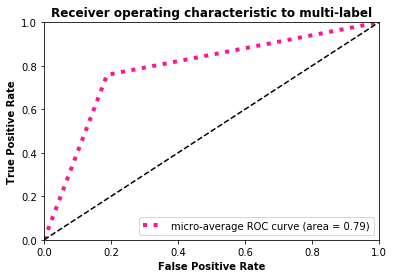

In [20]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(y_train.shape[1])]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(y_train.shape[1]):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= y_train.shape[1]

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

#plt.plot(fpr["macro"], tpr["macro"],
         #label='macro-average ROC curve (area = {0:0.2f})'
               #''.format(roc_auc["macro"]),
         #color='navy', linestyle=':', linewidth=4)

#colors = cycle(['red','green','violet','blue','black','orange','yellow','magenta',
               # 'red','green','violet','blue','black','orange','yellow','magenta',
               # 'red','green','violet','blue'])
#print(colors)
#for i, color in zip(range(y_train.shape[1]), colors):
   # plt.plot(fpr[i], tpr[i], color=color,
             # label='ROC curve of class {0} (area = {1:0.2f})'
             # ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('Receiver operating characteristic to multi-label', fontweight='bold')
plt.legend(loc="lower right")
plt.show()